In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import ticker, cm
from material_models import Fung, GOH
from NODE_fns import forward_pass, NN
import pickle

In [2]:
#Load the NN
with open('savednet/P1C1_Fung.npy', 'rb') as f:
    Fung_wb = pickle.load(f)
with open('savednet/P1C1_GOH.npy', 'rb') as f:
    GOH_wb = pickle.load(f)

In [3]:
def matrix_from_stretch(lm1, lm2, lm3):
    zeros = np.zeros(lm1.shape)
    F = np.array([[lm1, zeros, zeros], [zeros, lm2, zeros], [zeros, zeros, lm3]]).transpose((2,0,1))
    C = np.einsum('...ij,...jk->...ik', F, F.transpose(0,2,1))
    return F, C

In [4]:
lm = np.linspace(0.8, 1.3, 50)
lm1, lm2 = np.meshgrid(lm, lm)
lm3 = 1/(lm1*lm2)
F, C = matrix_from_stretch(lm1.flatten(), lm2.flatten(), lm3.flatten())
E = 0.5*(C-np.eye(3))

I1 = np.trace(C, axis1 = 1, axis2 = 2)
C2 = np.einsum('...ij,...jk->...ik', C, C)
I2 = 0.5*(I1**2 - np.trace(C2, axis1 = 1, axis2 = 2))
theta = Fung_wb[-1]
v0 = np.array([ np.cos(theta), np.sin(theta), 0])
w0 = np.array([-np.sin(theta), np.cos(theta), 0])
V0 = np.outer(v0, v0)
W0 = np.outer(w0, w0)
I4v = np.einsum('pij,ij->p', C, V0)
I4w = np.einsum('pij,ij->p', C, W0)

I1hat = I1-3
I2hat = I2-3
I4vhat = I4v-1
I4what = I4w-1
#Integrate to get Psi
Psi_NN_Fung = np.zeros_like(I1)
Psi_NN_GOH = np.zeros_like(I1)

In [5]:
def eval_Psi_i(i, I, params): #First index: which partial deriv do you want? Second index: array of invariants
    J_weights = np.abs(params[10])
    J = np.zeros(6)
    J[0] = I[0] + I[1]
    J[1] = I[0] + I[2]
    J[2] = I[0] + I[3]
    J[3] = I[1] + I[2]
    J[4] = I[1] + I[3]
    J[5] = I[2] + I[3]
    index_matrix = [[0,1,2], [0,3,4], [1,3,5], [2,4,5]] #Suppose i = 3, you know that I[3] appears in J[2], J[4] and J[5], hence [2,4,5].
    
    Psi_i = NN(np.array([I[i]]), params[i])
    for j in index_matrix[i]:
        Psi_i+= J_weights[j]*NN(np.array([J[j]]), params[j+4])
    return Psi_i

In [6]:
for i in range(Psi_NN_Fung.shape[0]):
    npoint = 20
#     npoint = int(np.max([I1hat[i], I2hat[i], I4vhat[i], I4what[i]])//0.01)
    dI1 = I1hat[i]/npoint
    dI2 = I2hat[i]/npoint
    dI4v = I4vhat[i]/npoint
    dI4w = I4what[i]/npoint
    
    dummyI1 = 0.0
    dummyI2 = 0.0
    dummyI4v = 0.0
    dummyI4w = 0.0
    for j in range(npoint):
        dPsidI1  = eval_Psi_i(0, [dummyI1, dummyI2, dummyI4v, dummyI4w], GOH_wb)
        dPsidI2  = eval_Psi_i(1, [dummyI1, dummyI2, dummyI4v, dummyI4w], GOH_wb)
        dPsidI4v = eval_Psi_i(2, [dummyI1, dummyI2, dummyI4v, dummyI4w], GOH_wb)
        dPsidI4w = eval_Psi_i(3, [dummyI1, dummyI2, dummyI4v, dummyI4w], GOH_wb)
        dPsidI1
        Psi_NN_GOH[i]+= dPsidI1*dI1 + dPsidI2*dI2 + dPsidI4v*dI4v + dPsidI4w*dI4w
        
        dPsidI1  = eval_Psi_i(0, [dummyI1, dummyI2, dummyI4v, dummyI4w], Fung_wb)
        dPsidI2  = eval_Psi_i(1, [dummyI1, dummyI2, dummyI4v, dummyI4w], Fung_wb)
        dPsidI4v = eval_Psi_i(2, [dummyI1, dummyI2, dummyI4v, dummyI4w], Fung_wb)
        dPsidI4w = eval_Psi_i(3, [dummyI1, dummyI2, dummyI4v, dummyI4w], Fung_wb)
        Psi_NN_Fung[i]+= dPsidI1*dI1 + dPsidI2*dI2 + dPsidI4v*dI4v + dPsidI4w*dI4w
        
        dummyI1+= dI1
        dummyI2+= dI2
        dummyI4v+= dI4v
        dummyI4w+= dI4w

F = F.reshape([50,50,3,3])
C = C.reshape([50,50,3,3])
E = E.reshape([50,50,3,3])
Psi_NN_Fung = Psi_NN_Fung.reshape([50,50])
Psi_NN_GOH = Psi_NN_GOH.reshape([50,50])
I1 = I1.reshape([50,50])
I2 = I2.reshape([50,50])
I4v = I4v.reshape([50,50])
I4w = I4w.reshape([50,50])

/opt/anaconda3/lib/python3.8/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [7]:
#Training Data
Fung_params = [0.0024147281291801714,-1.74859889140465,-21.453946421295953,49.84357587843394]
GOH_params = [1.02356332e-02, 5.13664702e-01, 5.91491834e+01, 2.74447648e-01, 1.57079633e+00]

Fung_MM = Fung(Fung_params)
Psi_Fung = Fung_MM.Psi(np.array([lm1.flatten(), lm2.flatten()]).T).reshape([50,50])
GOH_MM = GOH(GOH_params)
Psi_GOH = GOH_MM.Psi(np.array([lm1.flatten(), lm2.flatten()]).T).reshape([50,50])

<ipython-input-8-16aca059878f>:32: UserWarning: Log scale: values of z <= 0 have been masked
  cntr = ax3.contourf(E[:,:,0,0], E[:,:,1,1], Psi_Fung*1000, locator=ticker.LogLocator(), cmap = 'Blues', extend='max', levels=levels)


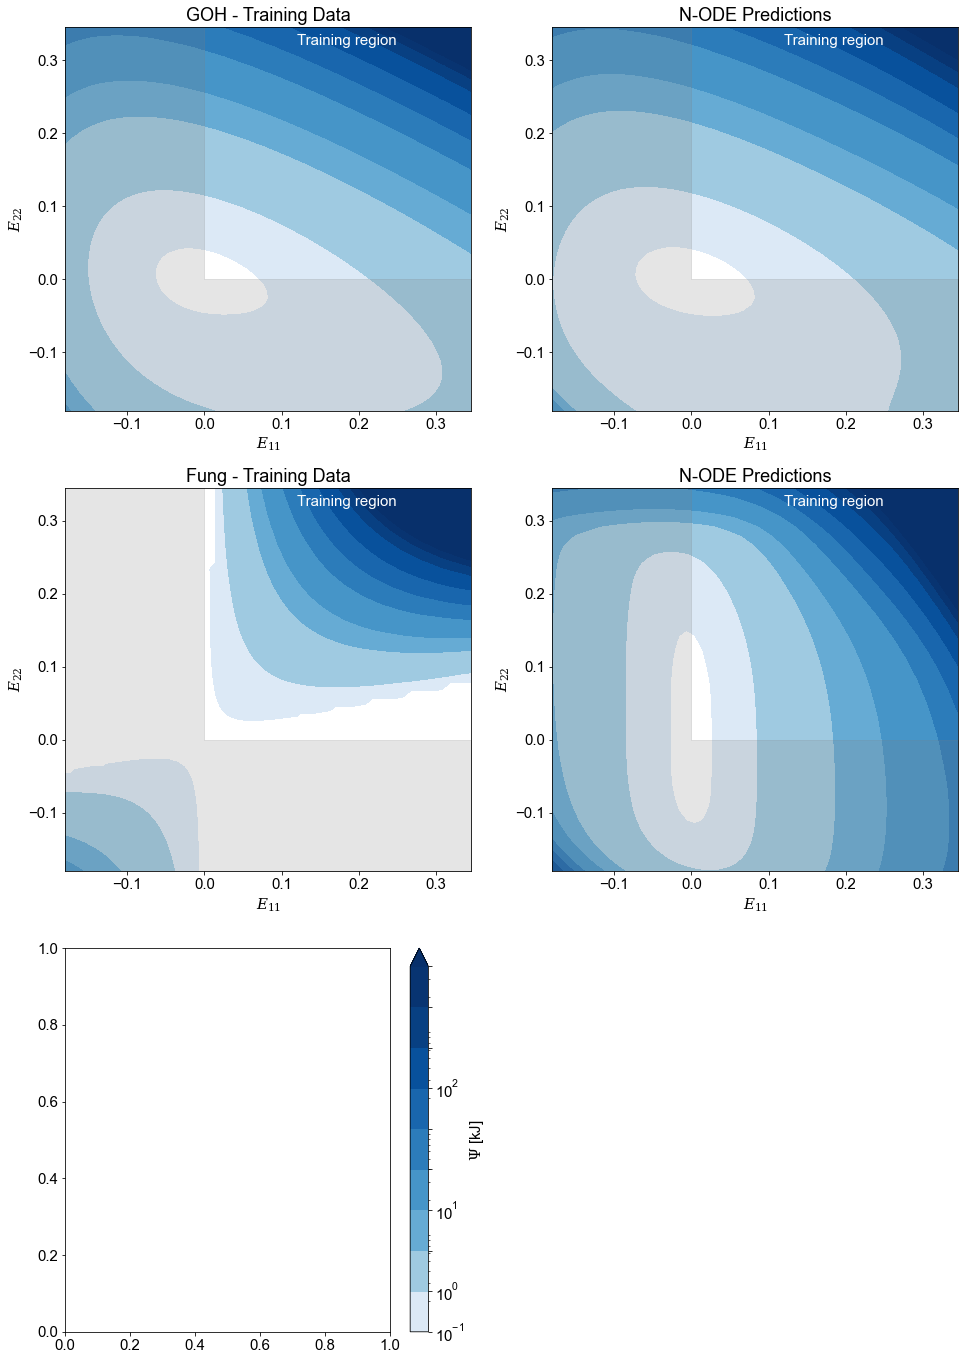

In [8]:
E0min = np.min(E[:,:,0,0])
E0max = np.max(E[:,:,0,0])
E1min = np.min(E[:,:,1,1])
E1max = np.max(E[:,:,1,1])

fig = plt.figure(figsize=(16,24))
plt.rcParams.update({'font.size': 15})
plt.rcParams["mathtext.fontset"] = 'dejavuserif'
plt.rcParams.update({'font.sans-serif':'Arial'})
colors = np.zeros((E.shape[0],E.shape[1],4))
colors[:,:] = plt.cm.Blues(0.8)
fmt = matplotlib.ticker.FormatStrFormatter('%d')
ax1 = fig.add_subplot(321)
ax1.set(xlabel='$E_{11}$', ylabel='$E_{22}$', title = 'GOH - Training Data', xlim=[E0min, E0max])
levels = [0.1, 1, 5, 10, 25, 50, 100, 200, 300, 400]
cntr = ax1.contourf(E[:,:,0,0], E[:,:,1,1], Psi_GOH*1000, locator=ticker.LogLocator(), cmap = 'Blues', extend='max', levels=levels)
ax1.fill_between(x=[E0min, 0, 0, E0max], y1=[E1min, E1min, E1min, E1min], y2 = [E1max, E1max, 0, 0], color='gray', alpha = 0.2)
# ax1.plot([0,np.max(E[:,:,0,0])],[0,0], linestyle='--', c='k')
# ax1.plot([0,0],[0,np.max(E[:,:,1,1])], linestyle='--', c='k')
ax1.text(0.12,0.32,'Training region', c='w')

ax2 = fig.add_subplot(322)
ax2.set(xlabel='$E_{11}$', ylabel='$E_{22}$', title = 'N-ODE Predictions')
cntr = ax2.contourf(E[:,:,0,0], E[:,:,1,1], Psi_NN_GOH*1000, locator=ticker.LogLocator(), cmap = 'Blues', extend='max', levels=levels)
ax2.fill_between(x=[E0min, 0, 0, E0max], y1=[E1min, E1min, E1min, E1min], y2 = [E1max, E1max, 0, 0], color='gray', alpha = 0.2)
# ax2.plot([0,np.max(E[:,:,0,0])],[0,0], linestyle='--', c='k')
# ax2.plot([0,0],[0,np.max(E[:,:,1,1])], linestyle='--', c='k')
ax2.text(0.12,0.32,'Training region', c='w')

ax3 = fig.add_subplot(323)
ax3.set(xlabel='$E_{11}$', ylabel='$E_{22}$', title = 'Fung - Training Data')
cntr = ax3.contourf(E[:,:,0,0], E[:,:,1,1], Psi_Fung*1000, locator=ticker.LogLocator(), cmap = 'Blues', extend='max', levels=levels)
ax3.fill_between(x=[E0min, 0, 0, E0max], y1=[E1min, E1min, E1min, E1min], y2 = [E1max, E1max, 0, 0], color='gray', alpha = 0.2)
# ax3.plot([0,np.max(E[:,:,0,0])],[0,0], linestyle='--', c='k')
# ax3.plot([0,0],[0,np.max(E[:,:,1,1])], linestyle='--', c='k')
ax3.text(0.12,0.32,'Training region', c='w')

ax4 = fig.add_subplot(324)
ax4.set(xlabel='$E_{11}$', ylabel='$E_{22}$', title = 'N-ODE Predictions')
cntr = ax4.contourf(E[:,:,0,0], E[:,:,1,1], Psi_NN_Fung*1000, locator=ticker.LogLocator(), cmap = 'Blues', extend='max', levels=levels)
ax4.fill_between(x=[E0min, 0, 0, E0max], y1=[E1min, E1min, E1min, E1min], y2 = [E1max, E1max, 0, 0], color='gray', alpha = 0.2)
# ax4.plot([0,np.max(E[:,:,0,0])],[0,0], linestyle='--', c='k')
# ax4.plot([0,0],[0,np.max(E[:,:,1,1])], linestyle='--', c='k')
ax4.text(0.12,0.32,'Training region', c='w')

ax5 = fig.add_subplot(325)
fig.colorbar(cntr,ax=ax5, label='$\Psi$ [kJ]')
fig.savefig('Figures/rfig_convexity.jpg', dpi=400, bbox_inches='tight')
pass